In [ ]:
vlib = c("tidyverse", "arrow", "ggsci", "ggpubr", "ggrepel",
         "scales", "ComplexUpset", "mashr", "patchwork", "pheatmap")
lapply(vlib, require, character.only = TRUE, quietly = TRUE) |>
  suppressMessages()

base_dir = "."
setwd(base_dir)

df_meta_target = read_delim("assets/file_meta.txt",
                     col_names = c("levels", "time", "cluster_name")) %>%
  mutate(prefix_file = paste0(levels, "_", time, "_", cluster_name))


df_map_cis = read_delim("/data/nfs_dell/project_HS/202310-sceqtl_v6/mashr_intra_eqtl/joined_all_results.txt.gz")

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

Rows: 16 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): levels, time, cluster_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 69897 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): phenotype_id, variant_id, condition, prefix_file, name
dbl (10): lfsr, PosteriorMean, PosteriorSD, start_distance, af, ma_samples, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## figure 1F, upset plot

In [17]:
df_map_cis %>% filter(lfsr < 0.05) %>% group_by(prefix_file) %>% summarise(n = n()) %>%
  mutate(str_sub(prefix_file, 9, -1))

prefix_file,n,"str_sub(prefix_file, 9, -1)"
<chr>,<int>,<chr>
anno_l1_1st_B,87,1st_B
anno_l1_1st_CD4,528,1st_CD4
anno_l1_1st_CD8,962,1st_CD8
anno_l1_1st_DC,73,1st_DC
anno_l1_1st_Mono,1195,1st_Mono
anno_l1_1st_NK,1087,1st_NK
anno_l1_1st_Other,165,1st_Other
anno_l1_1st_Other_T,172,1st_Other_T
anno_l1_base_B,98,base_B


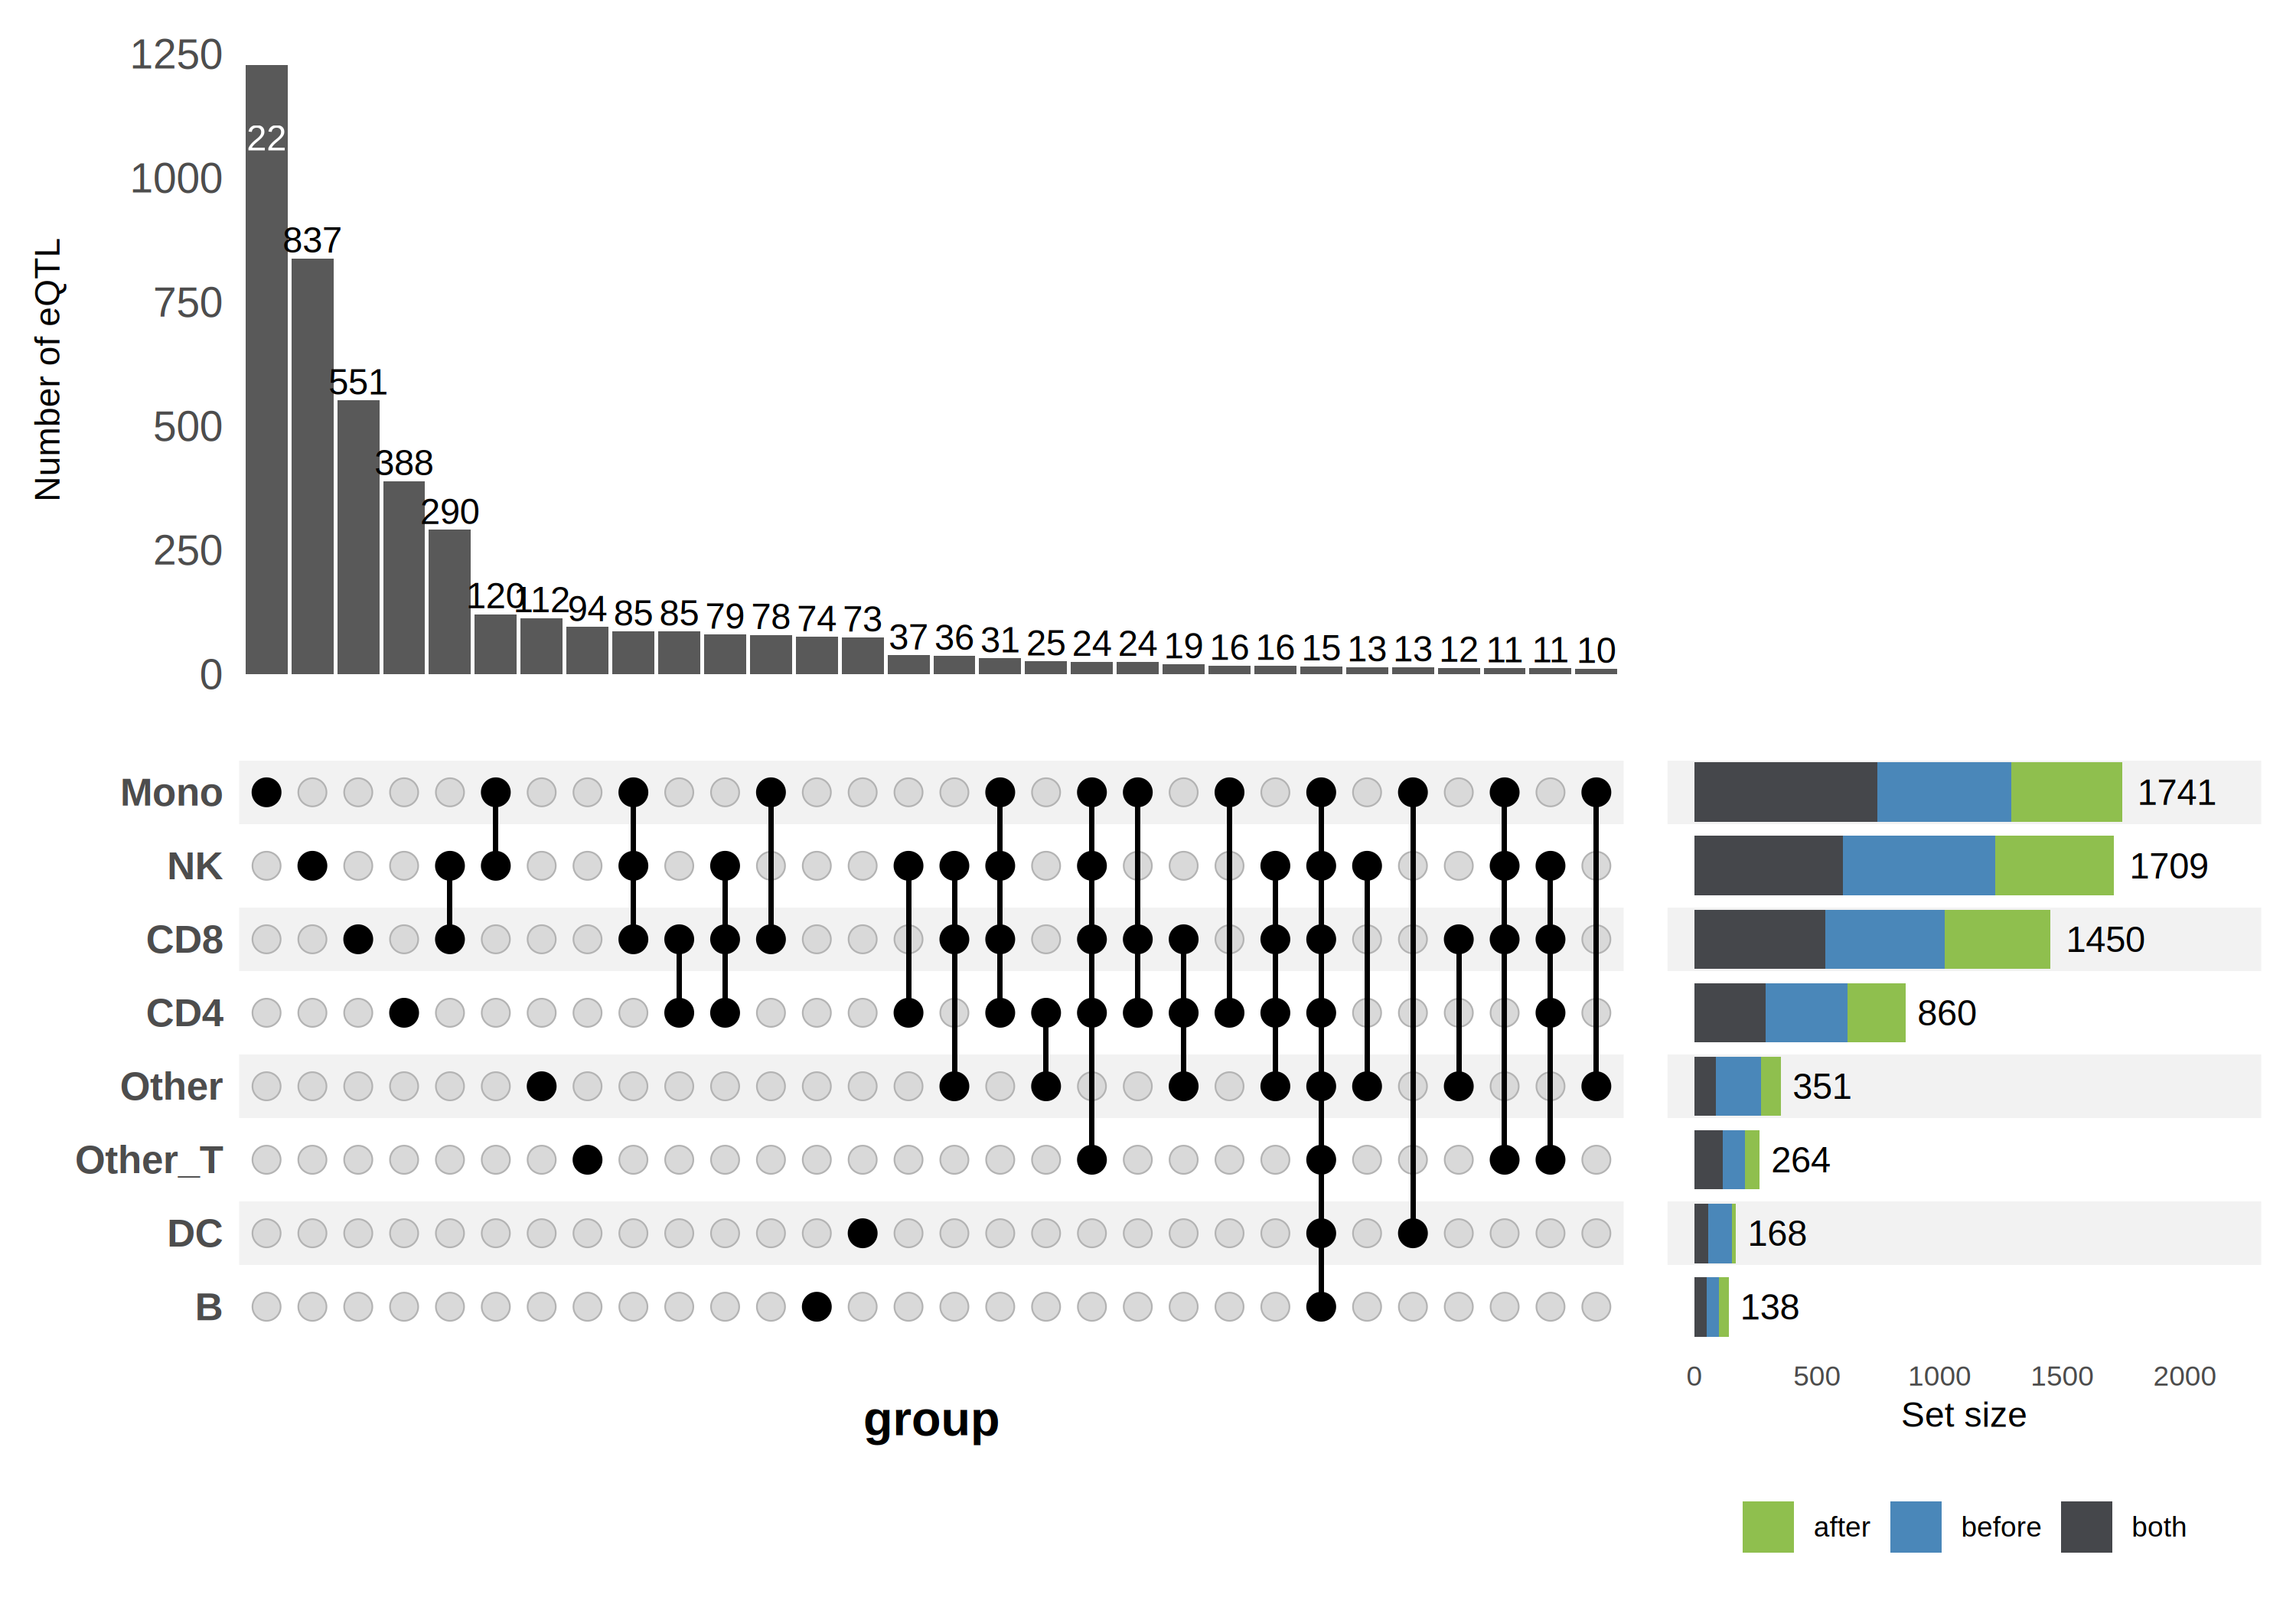

In [31]:

p_upset_full = upset(
  df_significant_upset_wide,
  c_intersections,
  sort_intersections = "descending",
  min_size = 10,
  base_annotations = list(
    "Intersection size" = (
      # removing number of eQTLs for visibility. (size = 0)
      intersection_size() +
        theme(plot.background = element_rect(fill = NA),
              axis.text.y = element_text(size = 13)) +
        ylab("Number of eQTL")
    )
  ),
  set_sizes = (
    upset_set_size(
      geom = geom_bar(aes(x = group, fill = time), width = 0.8), position = "right"
    ) +
      geom_text(aes(label = after_stat(count)), hjust = -0.2, stat = "count") +
      expand_limits(y = 2200) +
      scale_fill_manual(
        values = c(
          "after" = "#8FBF4E",
          "before" = "#4A87B9",
          "both" = "#45474B"
        )
      )
  ),
  height_ratio = 0.9,
  themes = upset_modify_themes(
    list(
      "intersections_matrix" = theme(
        text = element_text(size = 15, face = "bold")
      )
    )
  )
) & theme(
  plot.background = element_rect(fill = "transparent", color = NA),
  panel.grid = element_blank(),
  legend.position = "bottom"
)

options(repr.plot.height = 7, repr.plot.width = 10, repr.plot.res = 300)
print(p_upset_full)

#ggsave("visualization_upset/upset_time_all_full_v2_cut.pdf",
#       p_upset_full,
#       width = 50, height = 18, units = "cm", dpi = 300)

## figure 1G, cell counts - eQTL counts regression

Rows: 16 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): anno_l1, time
dbl (2): n_cells, n_cisQTL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


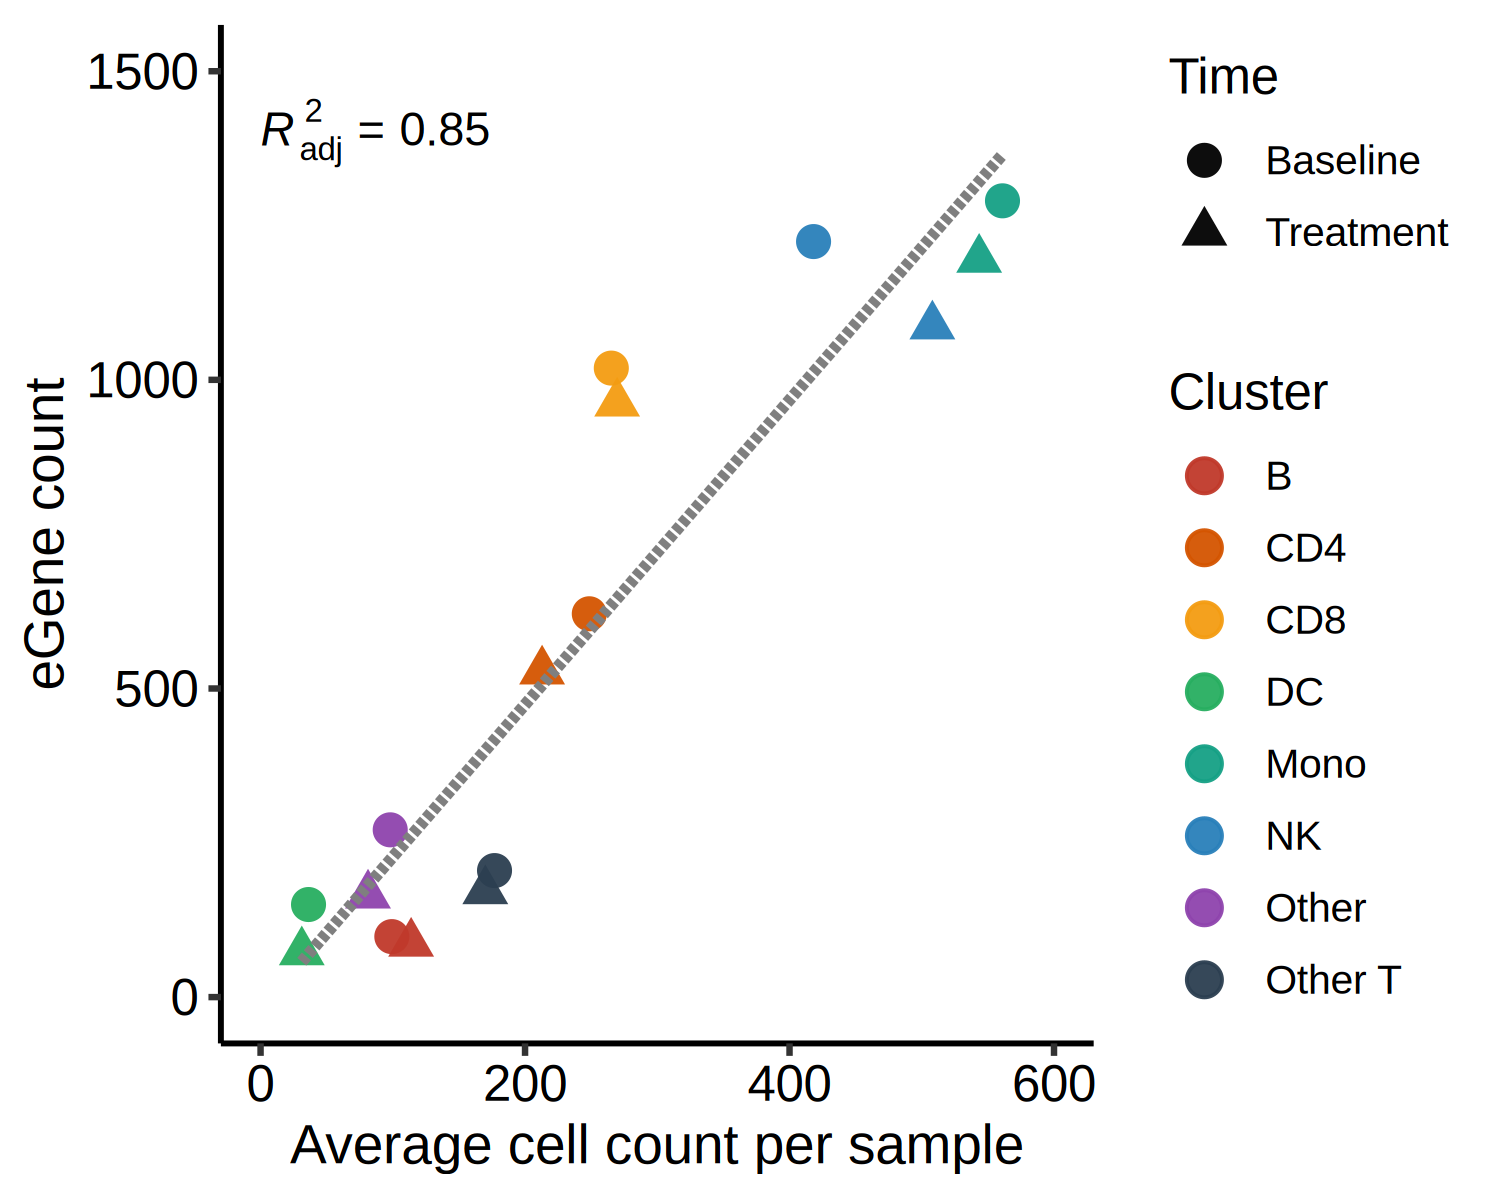

In [32]:

base_stat = read_delim("/data/nfs_dell/project_HS/codebase-HS/202310-sceQTL-v6/post_processing/ncells_cisQTL_statistics_v2.txt")

p_count_eQTL = base_stat %>% 
  mutate(Time = factor(ifelse(time == "before", "Baseline", "Treatment"), levels = c("Baseline", "Treatment")),
         Cluster = str_replace(anno_l1, pattern = "_", replace = " ")) %>%
  ggplot(aes(x = n_cells/146, y = n_cisQTL)) + 
  geom_point(aes(color = Cluster, shape = Time), size = 3.5, alpha = 0.95)+
  geom_smooth(method = "lm",se = FALSE, linetype = 5, color = "grey50")+
  scale_x_continuous(limits = c(0,600))+
  scale_y_continuous(limits = c(0,1500))+
  scale_color_flatui()+
  stat_regline_equation(
    aes(label =  paste(after_stat(adj.rr.label))),
  )+
  xlab('Average cell count per sample')+
  ylab('eGene count')+
  theme_pubr(legend = "right")+
  theme(axis.title = element_text(size = 13))
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)
p_count_eQTL
ggsave("figure_prep/p_count_cell_eqtl_v2.pdf",p_count_eQTL, units = "cm", width = 12, height = 10, dpi = 300)

## figure 1H, TSS distribution

In [ ]:
p_TSS_distribution = df_map_cis %>% 
  mutate(name = paste0(phenotype_id, "_", variant_id)) %>%
  group_by(name) %>%
  top_n(n = 1, -lfsr) %>%
  mutate(color = ifelse(lfsr < 0.05, "eGene", "non-eGene")) %>%
  distinct(phenotype_id, variant_id, start_distance, name, color) %>%
  ggplot(aes(x = start_distance, y = after_stat(density))) +
  geom_histogram(aes(fill = color), position = "identity", alpha = 0.8, bins = 100) +
  geom_density(alpha = 1, linewidth = 1) +
  scale_fill_manual(values = c("#13399d", "grey45")) +
  facet_wrap(~color, scales = "free_y") +
  theme_pubr(legend = "top") +
  #ggtitle("distance distribution from each best eSNP-eGene pair")+
  scale_x_continuous(breaks = c(-1e6, 0, 1e6),
                     label = c("-1Mb", "0", "1Mb")) +
  theme(
    plot.title = element_text(size = 18, hjust = 0),
    axis.title = element_text(size = 16),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank(),
    axis.line = element_blank(),
    legend.text = element_text(size = 14),
    legend.key.size = unit(2, "mm"),
    #legend.position = "right",
    strip.background = element_rect(fill = NA),
    strip.text = element_text(size = 16),
    panel.border = element_rect(linewidth = 1, fill = NA, color = "black")
  )

ggsave("figure_prep/pTSS_top_distribution.pdf",
      p_TSS_distribution,
      units = "cm", dpi = 300, width = 12, height = 12)

## figure 2A, sharing heatmap

In [ ]:

df_sharing = read_delim("assets/mash_sharing_stats.txt.gz")
c_heatmap_scale = colorRampPalette(c("#53799d","white","#E23222"), bias = 1.12)(21)

p_sharing = df_sharing %>%
  pheatmap(fontsize = 13,
    treeheight_row = 25,
    treeheight_col = 25,
    color = c_heatmap_scale
  )

print(p_sharing)

p_sharing
pdf("figure_prep/mashr_sharing_heatmap.pdf", width = 7.25, height = 7)
print(p_sharing)
dev.off()


## figure 2B kegg-based heatmap

In [ ]:
df_selected_genes_kegg = read_delim("assets/240414_kegg_selected_genes.txt",
                               delim = "\t", col_names = F) %>%
  mutate(X1 = factor(X1, levels = unique(df_selected_genes_stats$phenotype_id))) %>%
  arrange(X1)


p_beta_heatmap = df_map_cis %>% 
    filter(phenotype_id %in% df_selected_genes_kegg$X1
           ) %>% 
    group_by(phenotype_id) %>% mutate(min_lfsr = min(lfsr)) %>%
    filter(min_lfsr < 0.05) %>%
    arrange(-lfsr) %>% 
    mutate(PosteriorMean = ifelse(lfsr < 0.20, PosteriorMean, 0),
           slope = ifelse(lfsr < 0.20, slope, 0)) %>%
    left_join(df_meta_target, by = c("condition" = "prefix_file")) %>%
    mutate(condition = paste0(cluster_name, " ", ifelse(time == "base", "Before", "After"))) %>%
  select(phenotype_id, condition, PosteriorMean) %>%
  pivot_wider(names_from = condition, values_from = PosteriorMean, values_fill = 0) %>% 
  as.data.frame() %>% 
  column_to_rownames("phenotype_id") %>% 
  select(c("B Before", "B After", "DC Before", "DC After",
           "Mono Before", "Mono After", "NK Before", "NK After",
           "CD4 Before", "CD4 After", "CD8 Before", "CD8 After",
           "Other_T Before", "Other_T After", "Other Before", "Other After")) %>%
  as.matrix() %>%
  Heatmap(.,
          col = colorRamp2(c(-0.5, 0, 0.5), c("#53799d",'white','#E23222')),
          cluster_columns = F,
          row_split = df_selected_genes_kegg$X2)

print(p_beta_heatmap)


pdf("figure_prep/p_beta_heatmap.pdf", width = 7.25, height = 15)
print(p_beta_heatmap); dev.off()

## figure 2D, time-dependency

In [ ]:
# shared variables
annot_sharing = data.frame(
  color = c("TRUE-NA", "TRUE-FALSE", "TRUE-TRUE", "FALSE-TRUE", "NA-TRUE"),
  eGene_category = c("before-spare", "before-only", "consistant", "after-only", "after_sparse")
)
c_cluster = c("B", "DC", "Other", "Other_T", "CD4",  "CD8", "NK", "Mono")

df_map_cis_non_sparse = left_join(df_map_cis, df_meta_target, by = c("condition" = "prefix_file")) %>%
  select(cluster_name, name, time, lfsr) %>%
  mutate(significance = ifelse(lfsr < 0.05, TRUE, FALSE)) %>%
  select(-lfsr) %>%
  pivot_wider(names_from = time, values_from = significance) %>%
  mutate(color = factor(paste0(base, "-", `1st`),
                        levels = c("TRUE-FALSE", "TRUE-TRUE", "FALSE-TRUE"))) %>%
  filter(!is.na(color)) %>%
  select(-3,-4)


# time-dep stats 
df_map_cis_time_dependent = left_join(df_map_cis, df_meta_target, by = c("condition" = "prefix_file")) %>%
  select(cluster_name, name, time, PosteriorMean) %>%
  filter(name %in% df_map_cis_non_sparse$name) %>%
  mutate(time = ifelse(time == "1st", "after", "before")) %>%
  pivot_wider(names_from = time, values_from = PosteriorMean) %>%
  left_join(., df_map_cis_non_sparse) %>%
  #na.omit(color) %>%
  left_join(., annot_sharing) %>%
  mutate(eGene_category = factor(eGene_category, levels = c("before-only", "after-only", "consistant"))) %>%
  group_by(cluster_name, name) %>%
  mutate(slope_ratio = max((abs(after) / abs(before)), (abs(before) / abs(after)))) %>%
  mutate(significance = ifelse((slope_ratio > 2 &
                                  (((abs(after) > abs(before)) & abs(after) > 0.5) |
                                     ((abs(before) > abs(after)) & abs(before) > 0.5))),
                               "time-dependent", "not-significant"))

df_map_cis_time_dependent %>%
  write_delim("assets/df_map_cis_time_dependent_signals.txt.gz", delim = "\t")

p_shared_beta = df_map_cis_time_dependent %>%
  ggplot(aes(x= before, y = after, color = significance)) +
  geom_point( shape = 16, size = 2) + 
  scale_x_continuous(limits = c(-2,2)) +
  scale_y_continuous(limits = c(-1.8, 1.8)) +
  scale_color_manual(values = c(alpha("grey70", 0.5), "#526D82")) +
  xlab("Posterior beta from before ICI treatment") +
  ylab("Posterior beta from after ICI treatment") +
  theme_pubr() +
  theme(
    plot.title = element_text(size = 18, hjust = 0),
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 14),
    axis.line = element_blank(),
    legend.text = element_text(size = 14),
    legend.key.size = unit(2, "mm"),
    panel.grid.major = element_line(color = "grey80",
                                    linewidth = 0.5,
                                    linetype = 2),
    strip.background = element_rect(fill = NA),
    strip.text = element_text(size = 16),
    panel.border = element_rect(linewidth = 1, fill = NA, color = "black")
  )

print(p_shared_beta)

p_shared_beta %>%
  ggsave("figure_prep/p_possible_time_dep.pdf", .,
         width = 14, height = 15, dpi = 300, units = "cm")

## figure 2C, 2E, 3E
we cannot provide the source data due to individual genotypes. the following code was used for drawing eQTL plots.

In [ ]:
library(pgenlibr)
pvar <- pgenlibr::NewPvar("path_to_pvar")
pgen <- pgenlibr::NewPgen("path_to_pgen",
                          pvar = pvar)
sample_id = read_delim("path_to_psam") %>%
  pull(IID)
gtf = read_delim("assets/gencode.v43.basic.tss_bed.txt")

c_colors = c(
  "B" = "#C0392BFF",
  "CD4" = "#D35400FF", 
  "CD8" = "#F39C12FF",
  "DC" = "#27AE60FF",
  "Mono" = "#16A085FF",
  "NK" = "#2980B9FF",
  "Other" = "#8E44ADFF",
  "Other_T" = "#2C3E50FF"
)
  

In [ ]:
name = "CTSW_chr11:65879634:A:G" # example.
target_id = str_split(name, "_")[[1]][1]
target_variant  = str_split(name, "_")[[1]][2]
target_chr = gtf %>% filter(gene_id == target_id) %>% pull(`#chr`)

var_id = c()
for (each in target_variant){
  var_id = append(var_id, GetVariantsById(pvar, each))
}

geno_mat <- pgenlibr::ReadList(pgen, var_id)
colnames(geno_mat) = target_variant
rownames(geno_mat) = sample_id

allele_extraction = str_split(target_variant, ":")
lab = c(paste0(allele_extraction[[1]][3],allele_extraction[[1]][3]),
        paste0(allele_extraction[[1]][3],allele_extraction[[1]][4]),
        paste0(allele_extraction[[1]][4],allele_extraction[[1]][4]))

In [ ]:
df_meta_nominal = df_meta_target %>%
  mutate(nominal = paste0("tensorqtl_nominal/", prefix_file, ".cis_qtl_pairs.", target_chr,".parquet"),
         exprs_raw = paste0("pseudobulk_pipeline/exprs_matrix_raw/", prefix_file, ".bed"),
         exprs = paste0("pseudobulk_pipeline/exprs_matrix/", prefix_file, ".bed.gz"))

list_bed_exprs = vector(mode = "list", length = nrow(df_meta_nominal))
list_bed_exprs = lapply(df_meta_nominal$exprs, read_delim)
names(list_bed_exprs) = df_meta_nominal$prefix_file

df_long_exprs = list_bed_exprs %>%
  bind_rows(.id = "prefix_file") %>%
  filter(phenotype_id == target_id) %>%
  select(-2, -3, -4) %>%
  pivot_longer(cols = 3:ncol(.), names_to = "sample_id", values_to = "exprs") %>%
  left_join(df_meta) %>%
  select(-1, -levels)

In [ ]:
df_si = read_delim("assets/sample_information.txt") %>%
  select(sample, time, Pathology, Age, Response) %>%
  mutate(time = factor(time, levels = c("before", "after")))

In [ ]:
df_max = df_long_exprs %>%
  na.omit() %>%
  group_by(cluster_name, time) %>%
  summarise(max_y = max(exprs)) %>%
  mutate(time = ifelse(time == "base", "before", "after")) %>%
  mutate(time = factor(time, levels = c("before", "after")))

df_parquet = df_map_cis %>% filter(phenotype_id == target_id)
df_summary = left_join(df_parquet, df_meta_target) %>%
  select(PosteriorMean, PosteriorSD, lfsr, cluster_name, time) %>%
  mutate(value = 0, exprs = 0) %>%
  mutate(time = ifelse(time == "base", "before", "after")) %>%
  mutate(time = factor(time, levels = c("before", "after"))) %>%
  mutate(value = as.factor(value)) %>%
  left_join(df_max) %>%
  na.omit()

dbl_max_y = max(na.omit(df_summary$max_y))

In [ ]:
p_eachQTL = geno_mat %>% as.data.frame() %>% rownames_to_column("sample_id") %>%
  pivot_longer(cols = 2:ncol(.)) %>%
  left_join(df_long_exprs) %>%
  filter(name == target_variant) %>%
  mutate(time = ifelse(time == "base", "before", "after")) %>%
  mutate(time = factor(time, levels = c("before", "after"))) %>%
  mutate(value = as.factor(value)) %>%
  left_join(df_si, by = c("sample_id" = "sample", "time")) %>%
  ggplot(aes(x = value, y = exprs)) +
  geom_text(data = df_summary,
            aes(y = dbl_max_y * 1.05,
                label = paste0("beta = ", format(PosteriorMean, digits = 3))),
            hjust = 0.1, vjust = 1, size = 3) +
  geom_smooth(aes(x = as.numeric(value), y = exprs), method ="lm", se = F) +
  geom_jitter(aes(color = cluster_name), size = 2,  shape = 16, alpha = 0.5,
              position= position_jitterdodge(jitter.width = 0.30, dodge.width = 0.85)) +
  geom_violin(aes(fill = cluster_name), width = 1, alpha = 0.3, linewidth = 0) +
  geom_boxplot(aes(fill = cluster_name), alpha = 0.2,
               width = 0.4, position = position_dodge(width = 1)) +
  facet_grid(time ~ cluster_name, scales = "free_y") + theme_pubr() +
  scale_x_discrete(label = lab) +
  scale_fill_manual(values = c_colors) +
  scale_color_manual(values = c_colors) +
  xlab(target_variant) +
  ylab(paste0(target_id," expression (Normalized)")) +
  theme(
    plot.title = element_text(size = 20, hjust = 0),
    axis.title.x = element_text(hjust = 0.5, size = 16),
    axis.title.y = element_text(hjust = 0.5, size = 16),
    axis.text.x =  element_text(size = 12),
    axis.text.y =  element_text(size = 12),
    strip.background = element_blank(),
    strip.text = element_text(size = 16),
    legend.text = element_text(size = 12),
    legend.key.size = unit(2, "mm"),
    legend.position = "right"
  )
p_eachQTL
# automatic saving determ.
#ggsave(paste0("visualization_eachQTL/time_dep/", name, "_eQTLplot.pdf"), p_sharing,
#       height = 15, width = (3 + 3 * length(unique(df_long_exprs$cluster_name))), units = "cm")